# Alzheimer textual explanation, visual explanation and classification
In this notebook there's all the procedure we do for the classification and for the explanation.

For the realization of this project i start from the code of my colleague.

In this notebook we suppose that you have already the dataset and the explanation, if else, 
you will run "Creation of the dataset" before this notebook.

In [1]:
import random, glob

import numpy as np
from matplotlib import pyplot as plt
from sys import platform
import os

from transformers import AutoTokenizer
import torch
import torch.nn as nn
from torch import optim
from torch.distributions import Categorical
from monai.data import DataLoader, CacheDataset

from tqdm.notebook import trange, tqdm

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

import importlib
import Utility
importlib.reload(Utility)

from Utility import get_gradcam, train_test_splitting, plot_grad_cam_explanation, preprocessing_text
from Models import VisionEncoderDecoder, TokenDrop

from alzheimer_disease.src.helpers.utils import get_device
from alzheimer_disease.src.modules.training import training_model
from alzheimer_disease.src.helpers.config import get_config
from alzheimer_disease.src.modules.preprocessing import get_transformations
from alzheimer_disease.src.models.densenetmm import DenseNetMM

2024-09-14 08:40:50.727181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 08:40:50.727221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 08:40:50.727946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 08:40:51.447451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Definition of all paths
dataset = 'oasis_aug'

_base_path = './alzheimer_disease/'
_config = get_config()
saved_path = os.path.join(_base_path, _config.get('SAVED_FOLDER'))
reports_path = os.path.join(_base_path, _config.get('REPORT_FOLDER'))
logs_path = os.path.join(_base_path, _config.get('LOG_FOLDER'))
_data_path = os.path.join(_base_path, _config.get('LOCAL_DATA'))
data_path, meta_path, explanation_path = [
    os.path.join(_data_path, dataset, 'data/'),
    os.path.join(_data_path, dataset, 'meta/'),
    os.path.join(_data_path, dataset, 'explainability/')
]

device = get_device()

if platform == 'win32':
    saved_path = saved_path.replace('/', '\\')
    reports_path = reports_path.replace('/', '\\')
    logs_path = logs_path.replace('/', '\\')
    data_path = data_path.replace('/', '\\')
    meta_path = meta_path.replace('/', '\\')
    explanation_path = explanation_path.replace('/', '\\')

saved_path, reports_path, logs_path, data_path, meta_path, explanation_path, device

('./alzheimer_disease/saved/',
 './alzheimer_disease/reports/',
 './alzheimer_disease/logs/',
 './alzheimer_disease/data/oasis_aug/data/',
 './alzheimer_disease/data/oasis_aug/meta/',
 './alzheimer_disease/data/oasis_aug/explainability/',
 'cuda')

In [3]:
SIZE = 128
OUTPUT_LENGHT = 1024
epochs = 30
name_model = 'DenseNetMM'

CHANNELS = ['T2w']

FEATURES = ['sex', 'age', 'bmi', 'education', 'cdr_memory', 'cdr_orientation', 'cdr_judgment', 'cdr_community', 'cdr_hobbies', 'cdr_personalcare', 'boston_naming_test', 'depression', 'sleeping_disorder', 'motor_disturbance']
MULTICLASS = True

In [4]:
densenet = DenseNetMM(
    in_channels = len(CHANNELS),
    in_size = SIZE,
    in_features_size= len(FEATURES),
    out_channels = 3 if MULTICLASS else 2,
    append_features = True,
    name=name_model
)

In [5]:
train_transform, eval_transform = get_transformations(size=SIZE)

train, val, test = train_test_splitting(
    data_folder=data_path,
    meta_folder=meta_path,
    explanation_folder=explanation_path,
    channels=CHANNELS,
    features=FEATURES,
    multiclass=MULTICLASS,
    verbose=True
)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

                    TRAINING            EVALUATION          TESTING             

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

subjects            379 (64.0 %)        102 (17.0 %)        114 (19.0 %)        

sessions            435 (63.6 %)        111 (16.23 %)       138 (20.18 %)       



In [6]:
train[0]

{'image': ['./alzheimer_disease/data/oasis_aug/data/OAS42280_MR_d3029/sub-OAS42280_sess-d3029_T2w.nii.gz'],
 'data': array([1.        , 0.28      , 0.48333333, 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.25      , 1.        , 1.        , 0.5       ]),
 'label': 0.0,
 'explanation': "**Summary of Heatmap Analysis**\n\nThe heatmap analysis highlights regions of the brain that the classifier model focused on to make its classification decision, which is classified as Alzheimer's Disease. The regions highlighted in the heatmap are not areas affected by the disease, but rather areas that the model considered important for its decision.\n\n**Region 1: Frontal-to-Occipital (GapMap) left (19.9% of the heatmap)**\n\nThe Frontal-to-Occipital (GapMap) region is responsible for processing visual information and integrating it with other cognitive processes. The model's focus on this region may indicate that it is searching for patterns or f

In [7]:
if glob.glob(saved_path+ f'{name_model}_best.pth'):
	print(f'Loading {name_model}_best.pth')
	densenet.load_state_dict(torch.load(saved_path + f'{name_model}_best.pth'))
else:
	print('Train of the model')
	train_metrics = training_model(
		model = densenet,
		data = [train, val],
		transforms = [train_transform, eval_transform],
		epochs = epochs,
		device = get_device(),
		paths = [saved_path, reports_path, logs_path],
		num_workers=0,
		verbose=True
	)

Loading DenseNetMM_best.pth


## Image Captioning

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/ext/home/vlosavio5/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
# Define the learning rate for the optimizer
learning_rate = 1e-4

# Embedding Size
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

epochs_transformer = 50

# MultiheadAttention Heads
num_heads = 8

# Add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
sos_token = 101 * torch.ones(1, 1).long()
output_lenght=len(train[0]['explanation'])

# Set the temperature for sampling during generation
temp = 0.6

# Size of the patches
patch_size = 8

# Create model
caption_model = VisionEncoderDecoder(
    image_size=SIZE, 
    channels_in=len(CHANNELS), 
    num_emb=tokenizer.vocab_size,
    patch_size=patch_size, 
    num_layers=num_layers,
    hidden_size=hidden_size, 
    num_heads=num_heads
).to(device)


# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

val_interval = 2
early_stopping = 5

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

In [18]:
def generate_caption(caption_model, inputs_img, sos_token, temp, output_lenght):
    log_tokens = [sos_token]
    caption_model.eval()
    
    with torch.no_grad():
        # Encode the input image
        with torch.cuda.amp.autocast():
            # Forward pass
            image_embedding = caption_model.encoder(inputs_img.to(device))
    
        # Generate the answer tokens
        for i in range(output_lenght):
            input_tokens = torch.cat(log_tokens, 1)
            
            # Decode the input tokens into the next predicted tokens
            data_pred = caption_model.decoder(input_tokens.to(device), image_embedding)
            
            # Sample from the distribution of predicted probabilities
            dist = Categorical(logits=data_pred[:, -1] / temp)
            next_tokens = dist.sample().reshape(1, 1)
            
            # Append the next predicted token to the sequence
            log_tokens.append(next_tokens.cpu())
            
            # Break the loop if the End-Of-Caption token is predicted
            if next_tokens.item() == 102:
                break
                
    # Convert the list of token indices to a tensor
    pred_text = torch.cat(log_tokens, 1)
    
    # Convert the token indices to their corresponding strings using the vocabulary
    pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)
    
    # Join the token strings to form the predicted text
    pred_text = "".join(pred_text_strings)
    
    return pred_text

## Training

In [19]:
name_transformer = f'CaptionTransformerModel'

Training model...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Early stopping, the model has stopped learning for 5 epochs


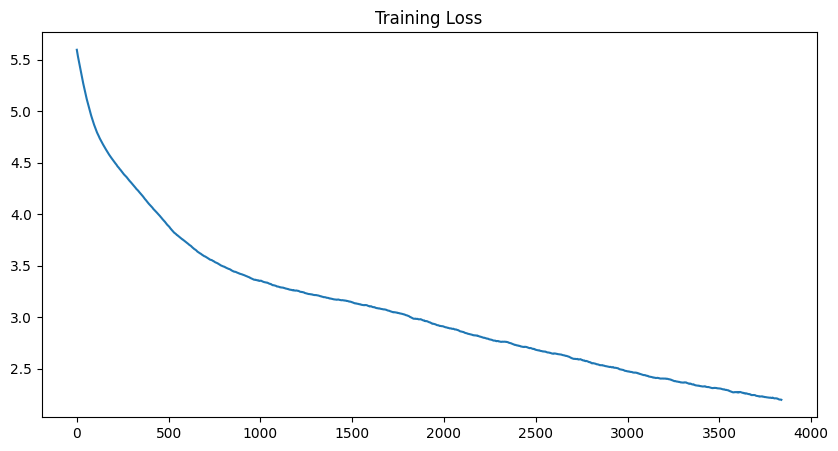

In [20]:
if glob.glob(saved_path+ f'{name_transformer}_best'):
	print(f'Loading {name_transformer}')
	caption_model = torch.load(saved_path + name_transformer+'_best')
else:
    print('Training model...')
    best_bleau = 0
    stopping = 0
    # Initialize the training loss logger
    training_loss_logger = []

    train_ds = CacheDataset(
        train, 
        transform=train_transform, 
        cache_rate=1.0,
        num_workers=None,
        progress=False
    )

    data_loader_train = DataLoader(train_ds, shuffle=True)



    device_torch = torch.device(device)

    caption_model.to(device_torch)
    # Iterate over epochs
    for epoch in trange(0, epochs_transformer, leave=False, desc="Epoch"):
        # Set the model in training mode
        caption_model.train()
        steps = 0
        # Iterate over the training data loader
        for data_t in data_loader_train:
            inputs_img, captions = (
                        data_t['image'].to(device_torch),
                        data_t['explanation']
                    )
            captions = preprocessing_text(captions[0])
            
            # Tokenize and pre-process the captions
            tokens = tokenizer(captions, padding=True, truncation=False, return_tensors="pt")
            token_ids = tokens['input_ids'].to(device_torch)
            padding_mask = tokens['attention_mask'].to(device_torch)
            bs = token_ids.shape[0]
            
            # Shift the input sequence to create the target sequence
            target_ids = torch.cat((token_ids[:, 1:], 
                                    torch.zeros(bs, 1, device=device).long()), 1)
            
            tokens_in = td(token_ids)
            with torch.cuda.amp.autocast():
                # Forward pass
                pred = caption_model(inputs_img, tokens_in, padding_mask=padding_mask)

            # Compute the loss
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

            # Backpropagation
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Log the training loss
            training_loss_logger.append(loss.item())

        # Validation
        if (epoch + 1) % val_interval == 0:
            caption_model.eval()
            
            val_ds = CacheDataset(
                val, 
                transform=eval_transform, 
                cache_rate=1.0,
                num_workers=None,
                progress=False
            )

            data_loader_val = DataLoader(val_ds, shuffle=True)
            
            ground_truth = []
            generated = []
            for data_t in data_loader_val:
                inputs_img, captions = (
                        data_t['image'].to(device_torch),
                        data_t['explanation']
                    )
                captions = preprocessing_text(captions[0])  
                sentence =  generate_caption(
                     caption_model=caption_model,
                     inputs_img=inputs_img,
                     sos_token=sos_token,
                     temp=temp,
                     output_lenght=output_lenght
                    )
                ground_truth.append(captions)
                generated.append(sentence)

                
            
            data_loader_val = None
            val_ds = None
            
            smoothie = SmoothingFunction().method5
            bleu_1 = corpus_bleu(ground_truth, generated, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
            if best_bleau < round(best_bleau, 4):
                print(f'Save best model with BLEU-1 = {bleu_1}')
                stopping = 0 
                best_bleau = bleu_1
                
                torch.save(caption_model, os.path.join(saved_path, name_transformer + '_best'))
            else:
                stopping += 1
                if stopping == early_stopping:
                    print(f"Early stopping, the model has stopped learning for {early_stopping} epochs")
                    break


    window_size = 512
    _data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode="valid")
    _ = plt.figure(figsize=(10, 5))
    _ = plt.plot(_data)
    _ = plt.title("Training Loss")


In [21]:
test_ds = CacheDataset(
        test, 
        transform=eval_transform, 
        cache_rate=1.0,
        num_workers=None,
        progress=False
    )


data_loader_test = DataLoader(test_ds, shuffle=True)

## Testing

In [22]:
computed_data = {
    'predicted': [],
    'ground_truth': [],
}

# Iterate over the training data loader
for data in tqdm(data_loader_test, desc="Testing", leave=False):
    inputs_img, captions = (
					data['image'].to(device),
					data['explanation']
				)

    captions = preprocessing_text(captions[0])
    pred = generate_caption(
        caption_model=caption_model,
        inputs_img=inputs_img,
        sos_token=sos_token,
        temp=temp,
        output_lenght=output_lenght
    )
    
    
    computed_data['predicted'].append(pred)
    computed_data['ground_truth'].append(captions)

Testing:   0%|          | 0/138 [00:00<?, ?it/s]

### Metrics for evaluation

In [24]:
def compute_metrics(original_sentences, completed_sentences):
    smoothie = SmoothingFunction().method5
    bleu_1 = corpus_bleu(original_sentences, completed_sentences, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = corpus_bleu(original_sentences, completed_sentences, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    
    for ref, gen in zip(original_sentences, completed_sentences):
        score = scorer.score(ref, gen)
        rouge_scores['rouge1'] += score['rouge1'].fmeasure
        rouge_scores['rouge2'] += score['rouge2'].fmeasure
        rouge_scores['rougeL'] += score['rougeL'].fmeasure

    n = len(original_sentences)
    rouge_scores = {k: v / n for k, v in rouge_scores.items()}

    return bleu_1, bleu_2, rouge_scores


In [26]:
bleu_1, bleu_2, rouge_scores = compute_metrics(computed_data['ground_truth'], computed_data['predicted'])

print(
    "BLEU-1: ", bleu_1,
    "\nBLEU-2: ", bleu_2,
    "\nRouge-1: ", rouge_scores['rouge1'],
    "\nRouge-2: ", rouge_scores['rouge2'],
    "\nRouge-L: ", rouge_scores['rougeL'],
)

BLEU-1:  0.3408564158146462 
BLEU-2:  0.19679354342559702 
Rouge-1:  0.7171239020110106 
Rouge-2:  0.475905786964569 
Rouge-L:  0.48378873010606843


# Merging the results of the proposed methods

In [27]:
def get_results_and_plot(or_image, predictor, generator, saved_path, sos_token, temp, output_lenght, plot=False):
    '''
    In this function we predict the class of the image after that we
    keep the Grad-CAM and the explanation and return them
    :param plot: if True we plot the Grad-CAM and explanation
    :param saved_path: directory where the model weights are stored
    :param image_dict: image dictionary
    :param predictor: model for predict all value
    :param generator: model for the generation of explanation
    :param tokenizer: tokenizer object
    :param max_length: maximum length of explanation
    :return: 
    '''
    
    # Keep the image, the mask and the prediction
    image, mask, pred, label, heatmap = get_gradcam(
        example=or_image,
        model=predictor,
        saved_path=saved_path,
        threshold=.8,
    )
    
    _, eval_transform = get_transformations(predictor.in_size)
    x = eval_transform([or_image])
    x_input = torch.unsqueeze(x[0]['image'], 0)
    
    # Generate the description from the processed image
    explanation = generate_caption(
        generator,
        x_input,
        sos_token,
        temp=temp,
        output_lenght=output_lenght
        )
    
    if plot:
        plot_grad_cam_explanation(image, label, pred, heatmap, mask, explanation)
    
    return  image, label, pred, heatmap, mask, explanation

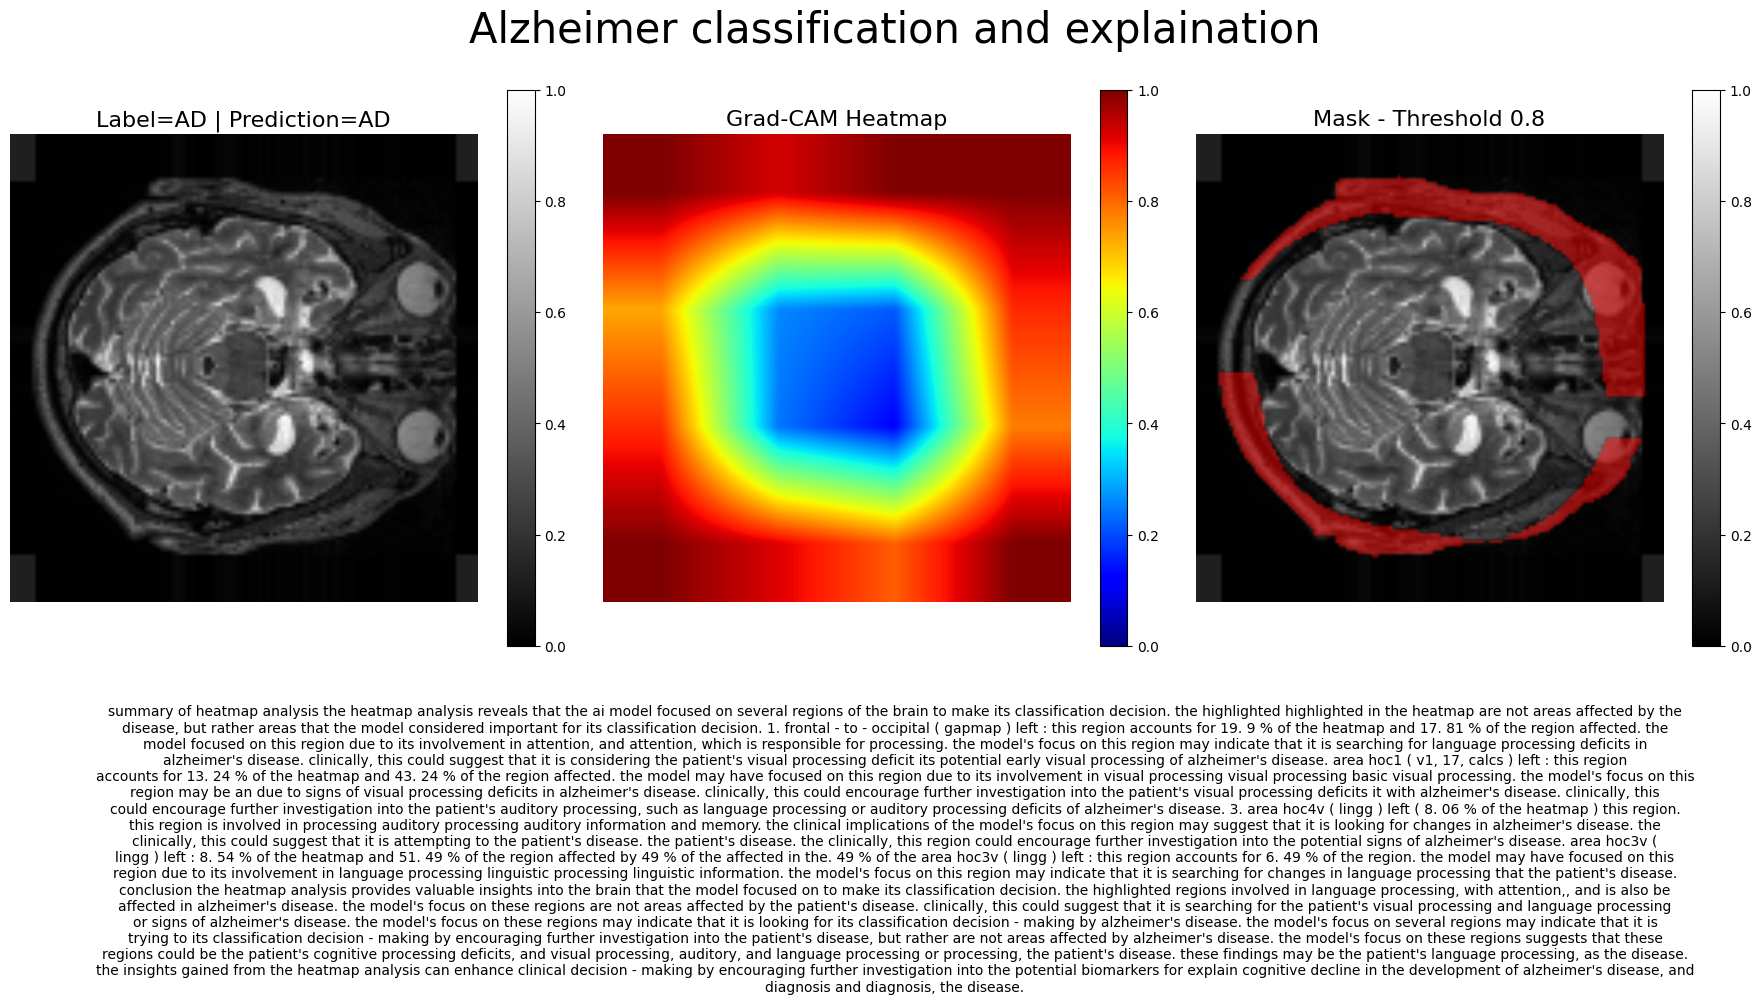

In [32]:
# get a random example from the validation set
example = test[random.randint(0, len(test)-1)]
_, _, _, _, _, explanation = get_results_and_plot(
    or_image=example,
    predictor=densenet,
    generator=caption_model,
    saved_path=saved_path,
    sos_token=sos_token,
    temp=temp,
    output_lenght=output_lenght,
    plot=True
)

In [34]:
with open('textual_results.txt', 'w') as file:
    file.write(f"""Original: {preprocessing_text(example['explanation'])}\n\n\nGenerated: {explanation}""")